# Lab 6: Mixture Models + Model order selection
**Students : Alassane DIALLO**

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2020@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

from sklearn.cluster import KMeans
from sklearn import metrics
import time
import pandas as pd
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [ ]:
def gaussian_pdf(x, mu, sigma):
        p = sigma.shape[0]
        # return (1/np.sqrt(2 * np.pi * (sigma ** 2))) * np.exp(-np.linalg.norm(x - mu)**2/(2 * (sigma ** 2)))
        return (1/((2 * np.pi)**p * np.linalg.det(sigma))**0.5) * np.exp(-0.5 * (x - mu) @ np.linalg.inv(sigma) @ (x - mu).T)

In [ ]:
class my_GMM():
    
    def __init__(self, k, init_method="random", nb_iter_max=100, eps=1e-2, random_state=0):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        assert init_method in ["random", "kmeans"]
        self.mu_ = None
        self.sigma_ = None
        self.cond_prob_ = None
        self.class_proba_ = None
        self.labels_ = None
        self.K_ = k
        self.eps_ = eps
        self.nb_iter_max_ = nb_iter_max
        self.random_state_ = random_state
        self.init_method_ = init_method
        self.init_time_ = None
        self.conv_time_ = None
            
    def fit(self, X, print_info=False):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n, p = X.shape
        K = self.K_
            
        def compute_condition_prob_matrix(X, mu, sigma, class_proba):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            cond_prob = np.zeros((n, K))
            for i in range(n):
                elems = []
                for k in range(K):
                    elems.append(class_proba[k] * gaussian_pdf(X[i], mu[k], sigma[k]))
                elems = np.array(elems)
                S =  np.sum(elems)
                for k in range(K):
                    cond_prob[i,k] = elems[k] / S
                # for k in range(K):
                #     cond_prob[i,k] = (class_proba[k] * gaussian_pdf(X[i], mu[k], sigma[k])) \
                #     /np.sum(np.array([class_proba[l] * gaussian_pdf(X[i], mu[l], sigma[l]) for l in range(K)]))
            return cond_prob
        
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        st = time.time()
        if self.init_method_=="random":
            np.random.seed(self.random_state_)
            labels = np.random.randint(low=0, high=K, size=n)
            clusters = np.array([np.where(labels==k)[0] for k in range(K)])
            centers = np.array([(1/len(clusters[k])) * np.sum(X[clusters[k]], axis=0) for k in range(K)])
            
        elif self.init_method_=="kmeans":
            kmeans = KMeans(n_clusters=self.K_, random_state=self.random_state_).fit(X)
            labels = kmeans.labels_
            clusters = np.array([np.where(labels==k)[0] for k in range(K)])
            centers = kmeans.cluster_centers_
        ed = time.time()
        init_time = ed - st

        self.labels_ = labels
        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters
        mu_old = np.zeros((K, p))
        sigma_old = np.eye(K)
        mu = centers
        sigma = np.array([(1/len(clusters[k])) * np.dot((X[clusters[k]] - mu[k]).T, (X[clusters[k]] - mu[k])) for k in range(K)])
        # sigma = np.array([(1/len(clusters[k])) * np.outer((X[clusters[k]] - mu[k]), (X[clusters[k]] - mu[k])) for k in range(K)])

        class_proba = np.ones(K) / K

                          
        delta = np.linalg.norm(mu - mu_old) / np.linalg.norm(mu)                 
        t = 0
        st = time.time()
        while not(delta<self.eps_ or t>self.nb_iter_max_):           
            mu_old = np.copy(mu)
            # for k in range(len(sigma)): print(sigma[k])
            cond_prob = compute_condition_prob_matrix(X, mu, sigma, class_proba)
            class_proba = (1/n) * np.sum(cond_prob, axis = 0)
            mu = np.array([(1/(n*class_proba[k])) * np.sum(np.array([X[i] * cond_prob[i,k] for i in range(n)]), axis=0) for k in range(K)])

            sigma = []
            for k in range(K):
                S = np.zeros((p, p))
                for i in range(n):
                    S= S + np.outer((X[i] - mu[k]), (X[i] - mu[k])) * cond_prob[i, k]
                S = (1/(n*class_proba[k])) * S
                sigma.append(S)
            sigma = np.stack(sigma)

            delta = np.linalg.norm(mu - mu_old) / np.linalg.norm(mu)
            t+= 1
        ed = time.time()
        conv_time = ed - st
                                 
        self.mu_ = mu
        self.sigma_ = sigma
        self.cond_prob_ = cond_prob
        self.class_proba_ = class_proba
        # Update labels_
        self.labels_ = np.array([np.argmax(cond_prob[i]) for i in range(n)])
        self.init_time_ = init_time
        self.conv_time_ = conv_time
        
        if print_info:
            print(f"initialization_time = {np.round(init_time, 3)} s")
            print(f"convergence_time = {np.round(conv_time, 3)} s")
            print(f"delta = {delta}")
            print(f"nb_iter = {t}")

                          
        # Return self
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        n, p = X.shape
        proba = self.compute_proba(X)
        labels = np.array([np.argmax(proba[i]) for i in range(n)])
        return labels
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n, p = X.shape
        K = self.K_
        proba = np.zeros((n, K))
        # TODO
        for i in range(n):
            for k in range(self.K_):
                proba[i,k] = (self.class_proba_[k] * gaussian_pdf(X[i], self.mu_[k], self.sigma_[k])) \
                        / np.sum(np.array([self.class_proba_[l] * gaussian_pdf(X[i], self.mu_[l], self.sigma_[l]) for l in range(K)]))
        return proba
        

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [ ]:
def gaussian_mixture_distribution(mu, sigma, N, p, random_state=0):
    np.random.seed(random_state)
    K = len(mu)
    n = np.sum([N[k] for k in range(K)])

    X = []
    labels = []
    for k in range(K):    
        X.append(np.random.multivariate_normal(mean=mu[k], cov=sigma[k] * np.eye(p), size = N[k]))
        labels.append(k * np.ones(N[k]))

    X = np.concatenate(X)
    labels = np.concatenate(labels)
    idx_shuffle = np.arange(n)
    np.random.shuffle(idx_shuffle)
    X = X[idx_shuffle]
    labels = labels[idx_shuffle]
    return X, labels.astype(int)

def plot_data(X, dimensions, real_labels, predicted_labels, mu=None, title=None):
    d1, d2 = dimensions
    plt.figure(figsize=(8,8))
    markers = ['o', '^', 's', 'x', '+', '.', ',', 'v', '<', '>', 'd']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'yellow']
    n = len(real_labels)
    unique_real_labels = np.unique(real_labels)
    for i in range(n):
        m = real_labels[i]
        c = predicted_labels[i]
        plt.plot(X[i, d1], X[i, d2], color=colors[c], marker=markers[m], markersize=10)
    unique_predicted_labels = np.sort(np.unique(predicted_labels))
    if mu is not None:
        for k in range(len(mu)):
            plt.plot(mu[k, 0], mu[k, 1], color=colors[unique_predicted_labels[k]], marker='+', markersize=20)
    if title is not None:
        plt.title(title)
    plt.show()

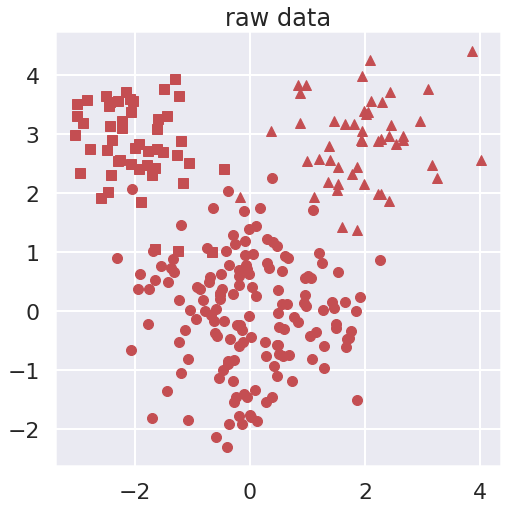

In [ ]:
p = 2
mu = [[0, 0], [2, 3], [-2, 3]]
sigma = [1, 0.5, 0.5]
K = len(mu)
N = [150, 50, 50]

X, real_labels = gaussian_mixture_distribution(mu, sigma, N, p, random_state=7)
plot_data(X, (0, 1), real_labels, np.zeros(X.shape[0]).astype(int), title="raw data")

Adjusted Rand Index = 0.85544


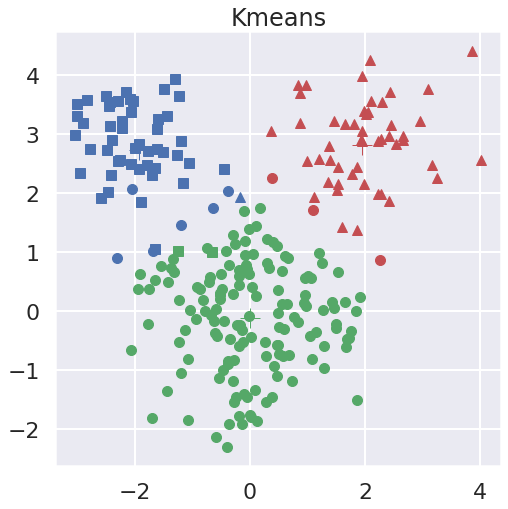

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(real_labels, kmeans.labels_), 5)}")
plot_data(X, (0, 1), real_labels, kmeans.labels_, mu=kmeans.cluster_centers_, title="Kmeans")

initialization_time = 0.026 s
convergence_time = 0.471 s
delta = 0.000856275529675937
nb_iter = 9
Adjusted Rand Index = 0.89772


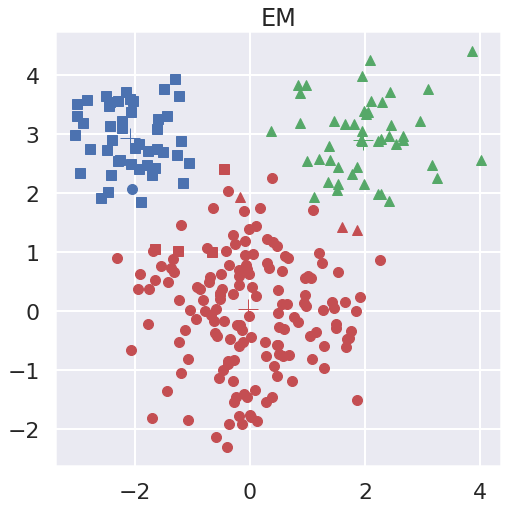

In [ ]:
gmm = my_GMM(k=3, init_method="kmeans", nb_iter_max=200, eps=1e-3, random_state=7)
gmm = gmm.fit(X, print_info=True)
predicted_labels = gmm.predict(X)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(real_labels, predicted_labels), 5)}")
plot_data(X, (0, 1), real_labels, predicted_labels, mu=gmm.mu_, title="EM")

initialization_time = 0.001 s
convergence_time = 2.041 s
delta = 0.0009620934714278127
nb_iter = 40
Adjusted Rand Index = 0.89772


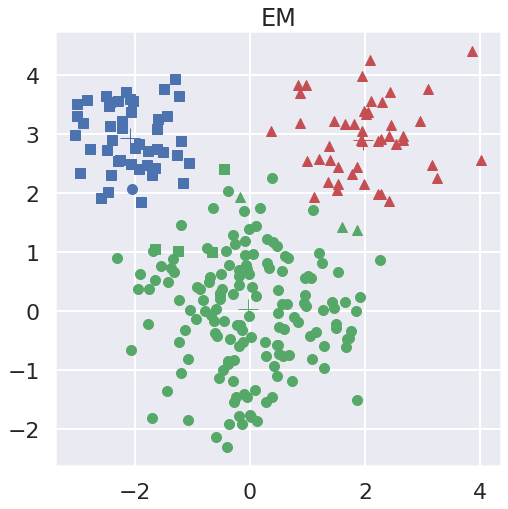

In [ ]:
gmm = my_GMM(k=3, init_method="random", nb_iter_max=200, eps=1e-3, random_state=7)
gmm = gmm.fit(X, print_info=True)
predicted_labels = gmm.predict(X)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(real_labels, predicted_labels), 5)}")
plot_data(X, (0, 1), real_labels, predicted_labels, mu=gmm.mu_, title="EM")

#### Comment
We generated a mixture distribution with 3 true classes. The parameters of the three classes are not the same, so that we obtain 3 clusters with different sizes and spatial distribution.
<br> To evaluate the performance of kmeans and the GMM in clustering the data, we used the adjusted rand index of sklearn that has the following definition:
$$RI = (a+b) / C_2^n$$
where:
- $a$ : number of samples in the same cluster and in the same true class (in the same time).
- $b$ : number of samples in different clusters and in different true class (in the same time).
- $C_2^n$ : Number of choices of 2 samples from n samples (without permutations).

<br> Applying a simple kmeans to cluster the data, we obtain clusters with the same size. Many points at the borders of the clusters are missclassified.
<br> A gaussian mixture model (GMM) with an Expectation Maximization (EM) gives better results (for the Rand index) and it adapts accurately to the size of each cluster.

<br> We also tried two initialization methods for EM: random and kmeans. We get exactly the same results (for the predicted labels and the rand index). We see that the initialisation time for the random cluster annotation is lower that the kmeans initialisation, but the convergence is slower because we need more iterations to get the stability of the clusters centroids.

### Second Part


#### Model order selection (generated data)
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

In [ ]:
def log_likelihood(X, gmm):
    n, p = X.shape
    K = gmm.mu_.shape[0]
    S = 0
    for i in range(n):
        for k in range(K):
            S+= gmm.cond_prob_[i,k] * np.log(gaussian_pdf(X[i], gmm.mu_[k], gmm.sigma_[k]) * gmm.class_proba_[k])
    return S

def AIC(X, gmm):
    nb_parameters = gmm.mu_.size + gmm.sigma_.size
    aic_ = log_likelihood(X, gmm) - nb_parameters
    return aic_

def BIC(X, gmm):
    n = X.shape[0]
    nb_parameters = gmm.mu_.size + gmm.sigma_.size
    bic_ = log_likelihood(X, gmm) - 0.5 * nb_parameters * np.log(n) 
    return bic_

In [ ]:
nb_clusters = [2, 3, 4, 5, 6]
AIC_0 = []
BIC_0 = []
for K in nb_clusters:
    gmm_0k = my_GMM(K, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
    gmm_0k = gmm_0k.fit(X, print_info=False)
    predicted_labels = gmm.predict(X)
    aic_0 = AIC(X, gmm_0k)
    bic_0 = BIC(X, gmm_0k)

    AIC_0.append(aic_0)
    BIC_0.append(bic_0)

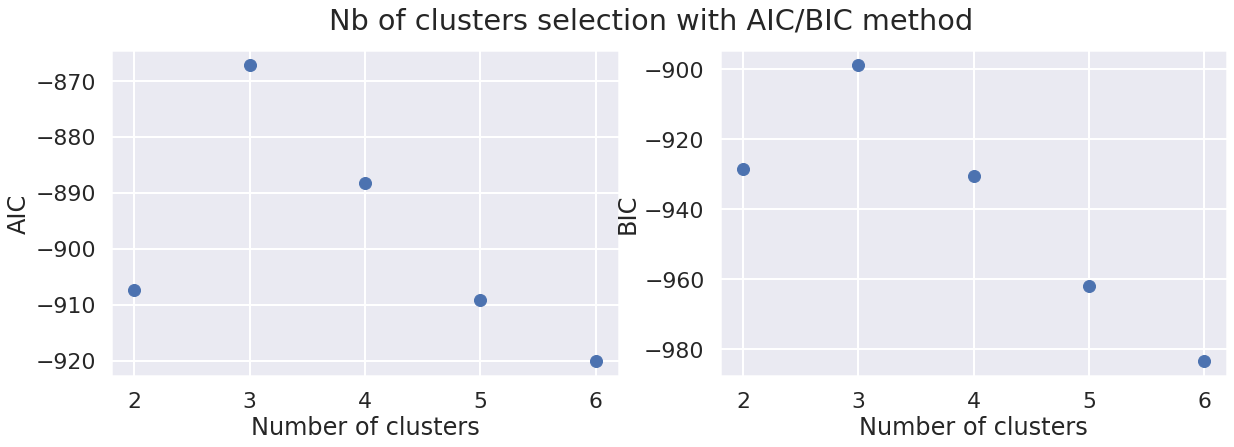

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(nb_clusters, AIC_0, 'o', label="AIC")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("AIC")

ax2.plot(nb_clusters, BIC_0, 'o', label="BIC")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("BIC")
plt.suptitle("Nb of clusters selection with AIC/BIC method")
plt.show()

The AIC and BIC both succeed at identifying a number of clusters equal to number of true classes. We see that 2 clusters is not enough to give the best likelihood of the model. Increasing the number of clusters results in the increase of model complexity which is penalized in AIC and BIC. This is much more observed in the case of BIC.

#### Model order reduction (generated data)

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

In [ ]:
def merge_two_clusters(X, i, j, labels, dict_mu, dict_sigma, recompute_cond_prob=False, dict_cond_prob=None, dict_class_proba=None):
    new_label = min(i, j)
    old_label = max(i, j)
    new_labels = np.copy(labels)
    new_labels[new_labels==i] = new_label
    new_labels[new_labels==j] = new_label
    
    n_i = len(np.where(labels==i)[0])
    n_j = len(np.where(labels==j)[0])

    dict_new_mu = dict_mu.copy()
    del dict_new_mu[old_label]
    dict_new_sigma = dict_sigma.copy()
    del dict_new_sigma[old_label]

    dict_new_mu[new_label] = (n_i * dict_mu[i] + n_j * dict_mu[j]) / (n_i + n_j)
    dict_new_sigma[new_label] = (n_i * dict_sigma[i] + n_j * dict_sigma[j]) / (n_i + n_j)
    
    if recompute_cond_prob:
        dict_new_class_proba = dict_class_proba.copy()
        del dict_new_class_proba[old_label]
        dict_new_cond_prob = dict_cond_prob.copy()
        del dict_new_cond_prob[old_label]

        dict_new_class_proba[new_label] = dict_class_proba[i] + dict_class_proba[j]
        n = X.shape[0]
        for i in range(n):
            elems = []
            for k in new_labels:
                elems.append(dict_new_class_proba[k] * gaussian_pdf(X[i], dict_new_mu[k], dict_new_sigma[k]))
            elems = np.array(elems)
            S =  np.sum(elems)
            for k in new_labels:
                dict_new_cond_prob[k][i] = elems[k] / S
        return new_labels, dict_new_mu, dict_new_sigma, dict_new_cond_prob, dict_new_class_proba

    
    return new_labels, dict_new_mu, dict_new_sigma, None, None

def array_to_dict(array):
    dict = {}
    for i in range(len(array)):
        dict[i] = array[i]
    return dict

def dict_to_array(dict):
    l = []
    keys = np.sort(np.array(list(dict.keys())))
    for key in keys:
        l.append(dict[key])
    return np.array(l)

def merge_clusters(X, gmm, criterion, nb_merges_max, eps, info=False):
    assert nb_merges_max < len(np.unique(gmm.labels_)), "Number of merges must be strictly inferior to the total number of clusters"
    assert criterion in ["distance", "intra_variance", "pearson_correlation"], "Criterion not implemented: choose between 'distance', 'intra_variance', 'pearson_correlation'"
    mu = gmm.mu_
    sigma = gmm.sigma_
    labels = gmm.labels_
    cond_prob = gmm.cond_prob_
    class_proba = gmm.class_proba_
    labels_merge = [labels]
    mu_merge = [mu]
    nb_merges = 0

    dict_mu = array_to_dict(mu)
    dict_sigma = array_to_dict(sigma)

    if criterion in ["intra_variance",]:
        eps = -eps
    if criterion in ["pearson_correlation",]:
        recompute_cond_prob = True
        dict_cond_prob = array_to_dict(cond_prob.T)
        dict_class_proba = array_to_dict(class_proba)
    else:
        recompute_cond_prob = False
        dict_cond_prob = None
        dict_class_proba = None

    for it in range(nb_merges_max): 
        metric = {}
        unique_labels = np.unique(labels)
        for i in dict_mu.keys():
            for j in dict_mu.keys():
                if j>i:
                    if criterion=="distance":          
                        metric[(i,j)] = np.linalg.norm(dict_mu[i] - dict_mu[j])
                    elif criterion=="intra_variance":
                        cluster_i = np.where(labels==i)[0]
                        cluster_j = np.where(labels==j)[0]
                        new_cluster = np.concatenate((cluster_i, cluster_j))
                        new_mu = (len(cluster_i) * dict_mu[i] + len(cluster_j) * dict_mu[j]) / (len(cluster_i) + len(cluster_j))
                        sigma_i = (1/len(cluster_i)) * np.sum(np.array([np.linalg.norm(X[l]-dict_mu[i])**2 for l in cluster_i]))
                        sigma_j = (1/len(cluster_j)) * np.sum(np.array([np.linalg.norm(X[l]-dict_mu[j])**2 for l in cluster_j]))
                        new_sigma = (1/len(new_cluster)) * np.sum(np.array([np.linalg.norm(X[l]-new_mu)**2 for l in new_cluster]))
                        metric[(i,j)] = new_sigma - (sigma_i + sigma_j)
                    elif criterion=="pearson_correlation":
                        pearson = stats.pearsonr(dict_cond_prob[i], dict_cond_prob[j])[0]
                        metric[(i,j)] = 1 - pearson                        

        min = np.inf
        couple_min = list(metric.keys())[0]
        for couple in metric:
            if metric[couple] < min: 
                min = metric[couple]
                couple_min = couple
                
        if min < eps:
            labels, dict_mu, dict_sigma, dict_cond_prob, dict_class_proba = merge_two_clusters(X, couple_min[0], couple_min[1], labels, dict_mu, dict_sigma, recompute_cond_prob, dict_cond_prob, dict_class_proba)
            labels_merge.append(labels)
            mu_merge.append(dict_to_array(dict_mu))
            nb_merges+= 1
        else:
            if info: print(f"Final number of clusters = {len(np.unique(labels_merge[-1]))}")
            return labels_merge, mu_merge
    if info: print(f"Final number of clusters = {len(np.unique(labels_merge[-1]))}")
    return labels_merge, mu_merge

In [ ]:
def plot_subplot_data(X, dimensions, real_labels, predicted_labels_merge, mu_merge=None, size=21, title=None, markersize=10):
    
    markers = ['o', '^', 's', 'x', '+', '.', ',', 'v', '<', '>', 'd']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'yellow']
    nb_subplots = len(predicted_labels_merge)
    r2 = 3
    r1 = nb_subplots // r2
    if nb_subplots % r2 != 0:
        r1+= 1

    d1, d2 = dimensions
    f, ax = plt.subplots(r1, r2, figsize=(size, (size//r2)*r1), squeeze=False)
    n = X.shape[0]
    unique_real_labels = np.unique(real_labels)

    num_merge = -1
    for a in range(r1):
        for b in range(r2):
            num_merge+= 1
            if num_merge >= len(predicted_labels_merge): break
            predicted_labels = predicted_labels_merge[num_merge]
            for i in range(n):
                if real_labels is not None:
                    m = real_labels[i]
                else:
                    m = 0
                c = predicted_labels[i]
                ax[a, b].plot(X[i, d1], X[i, d2], color=colors[c], marker=markers[m], markersize=markersize)
            unique_predicted_labels = np.sort(np.unique(predicted_labels))
            nb_clusters = len(unique_predicted_labels)
            if mu_merge is not None:
                mu = mu_merge[num_merge]
                for k in range(len(mu)):
                    ax[a, b].plot(mu[k, d1], mu[k, d2], color=colors[unique_predicted_labels[k]], marker='+', markersize=20) 
            ax[a, b].set_title(f"Nb_clusters = {nb_clusters}", fontdict={'fontsize': 15})
    if title is not None:
        f.suptitle(title, fontsize=25)
    plt.show()

We begin by setting an initial number of clusters, and then apply a model order selection on three criterion: centroid distance, intra-variance reduction and pearson correlation. We merge two clusters if:
- The distance of their centroid is less than epsilon.
- The intra-variance is reduced by more than epsilon.
- The pearson correlation of the two conditional probability matrix columns (corresponding to these two clusters) is close to 1 with an epsilon margin.

After each merge, we update the centroids, the covariance matrix in all cases. We also recompute (only for the pearson correlation case) the class probability vector and the conditional probability matrix, because we need them to evaluate the next pearson correlations.
<br> We specify a maximum number of merges (less than the initial number of clusters) and the algorithm stops when it does not find possible merges.

<br> By plotting the final number of clusters (after all the merges) to the parameter epsilon, we look to find a stable region where the change of epsilon does not induce further merges. This will help us detect a suitable epsilon and identify the right final number of clusters for the data.

In [ ]:
gmm_0 = my_GMM(k=10, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
gmm_0 = gmm_0.fit(X, print_info=True)

initialization_time = 0.062 s
convergence_time = 0.466 s
delta = 0.007579724765145868
nb_iter = 3


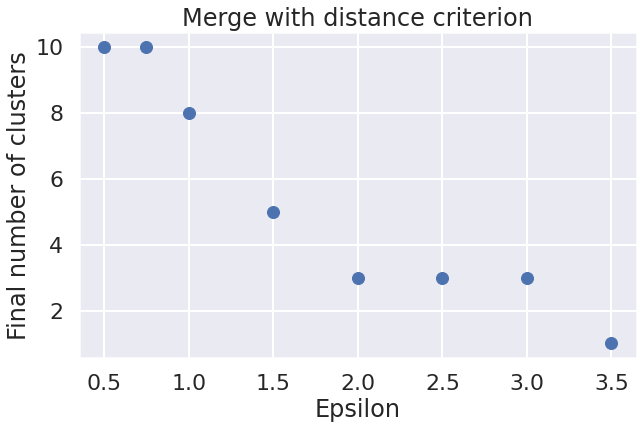

In [ ]:
eps_distance_0 = [0.5 ,0.75, 1, 1.5, 2, 2.5, 3, 3.5]
final_nb_clusters_distance_0 = []
for eps_ in eps_distance_0:
    labels_merge, mu_merge = merge_clusters(X, gmm_0, criterion="distance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_distance_0.append(len(np.unique(labels_merge[-1])))
plt.figure(figsize = (10,6))
plt.plot(eps_distance_0, final_nb_clusters_distance_0, 'o')
plt.xlabel("Epsilon")
plt.ylabel("Final number of clusters")
plt.title("Merge with distance criterion")
plt.show()

In [ ]:
eps_variance_0 = [0.5, 0.4, 0.3, 0.2, 0.15, 0.1, 0.05, 0.025, 0]
final_nb_clusters_variance_0 = []
for eps_ in eps_variance:
    labels_merge, mu_merge = merge_clusters(X, gmm_0, criterion="intra_variance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_variance_0.append(len(np.unique(labels_merge[-1])))

In [ ]:
eps_pearson_0 = [0.025, 0.05, 0.1, 0.2]
final_nb_clusters_pearson_0 = []
for eps_ in eps_pearson_0:
    labels_merge, mu_merge = merge_clusters(X, gmm_0, criterion="pearson_correlation", nb_merges_max=9, eps= eps_)
    final_nb_clusters_pearson_0.append(len(np.unique(labels_merge[-1])))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


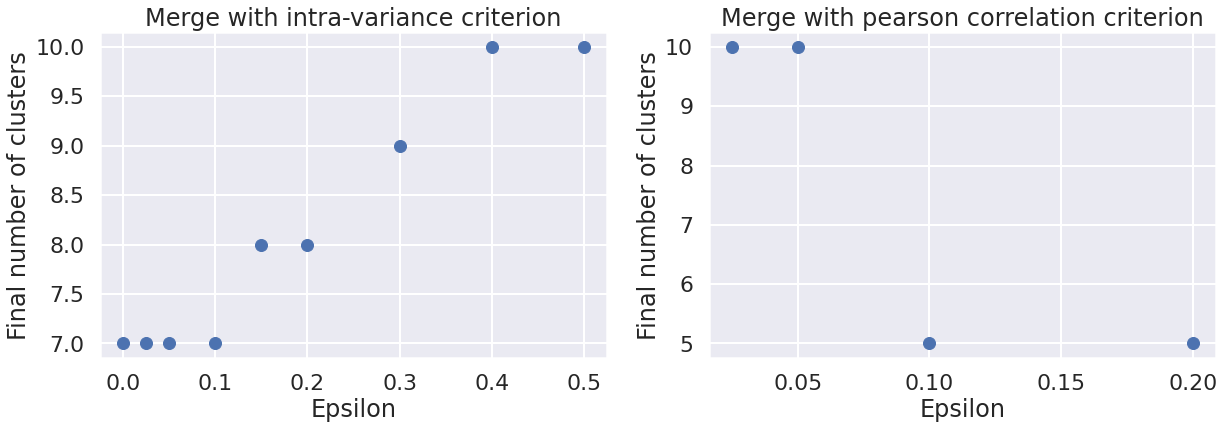

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(eps_variance_0, final_nb_clusters_variance_0, 'o')
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Final number of clusters")
ax1.set_title("Merge with intra-variance criterion")

ax2.plot(eps_pearson_0, final_nb_clusters_pearson_0, 'o')
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Final number of clusters")
ax2.set_title("Merge with pearson correlation criterion")
plt.show()

From the three figures above, we can give remarks:
- **For the distance criterion:** the increase of epsilon results in the merge of more clusters, but we observe a stable region for a final number of cluster 3 which corresponds to the number of true classes.
- **For intra-variance criterion:** the increase of epsilon means that we merge clusters than only reduce more the intra-variance, which gives a stricter constraint and explains the increase of final number of clusters. We see a stable region around 0, which means that the model order reduction does not decrease very much the intra-variance. This is maybe due to the spatial distribution of the data which is condensed in different areas distant from each other. If we had much more closer clusters with diffuse distribution, we would have reduced more the intra-variance by merging them.
- **For pearson correlation criterion:** Lower epsilon means that the merge constraint requires more similar distributions. We obtain a stable region starting from epsilon=0.1 which means that there are clusters that have (between each other) a relative pearson correlation close to 0.9. This procedure merged clusters with high degree of similarity.

We see that the distance criterion and AIC / BIC methods agree on the number of clusters (3), but the other method do not, because they rely on different degree of similarity. In the case of intra-variance, we look to obtain more dense clusters and for the pearson correlation, we want clusters that give similar distributions for the data. For the other methods (distance, AIC, BIC), we rely on the spatial position of the clusters that have an influence over the likelihood and the inter-distance.

We apply the model order reduction by choosing the distance criterion and a suitable epsilon. We plot below the merge procedure (step by step). We obtain a final number of clusters equal to the number of true classes and we have rand index (0.91) which is higher than the one we obtained without model order reduction (by choosing the number of clusters to 3), because we have a better clustering of the border points.

In [ ]:
labels_merge_0, mu_merge_0 = merge_clusters(X, gmm_0, criterion="distance", nb_merges_max=9, eps= 2.5, info=True)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(real_labels, labels_merge_0[-1]), 5)}")

Final number of clusters = 3
Adjusted Rand Index = 0.91072


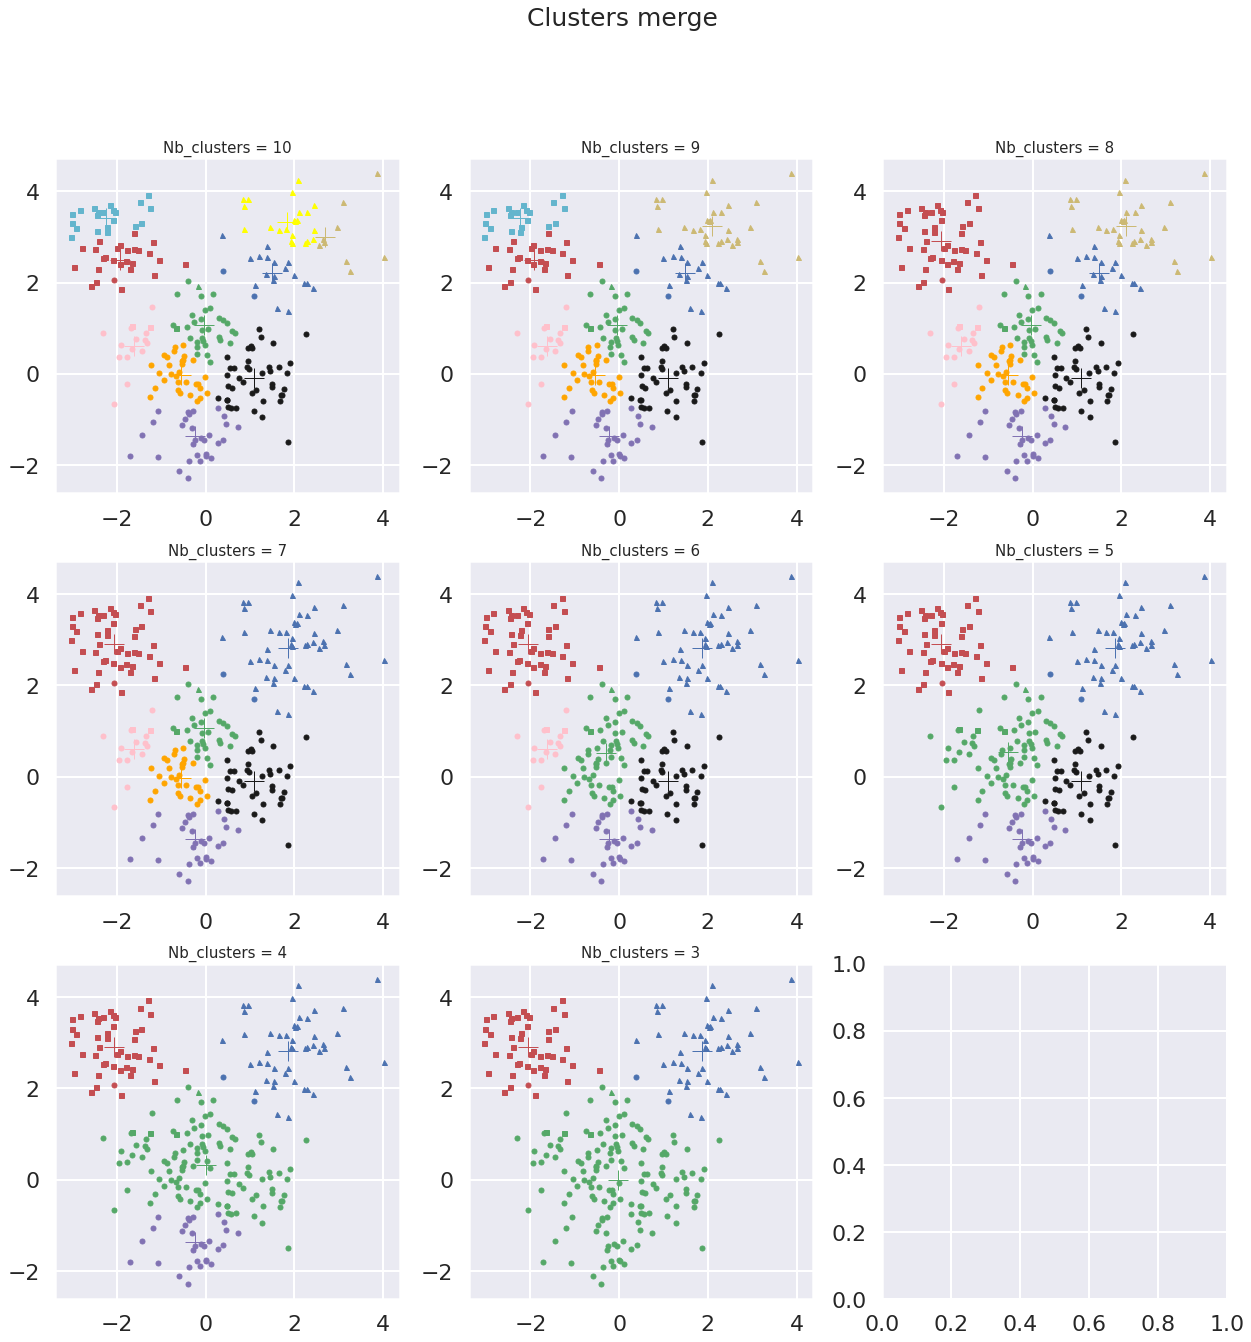

In [ ]:
plot_subplot_data(X, (0, 1), real_labels, labels_merge_0,  mu_merge=mu_merge_0, size=21, title="Clusters merge", markersize=5)

#### Model order selection vs reduction (1st dataset)

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

In [ ]:
data_1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_MM_1.csv",sep=',',header=None).to_numpy()
data_2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_MM_2.csv",sep=',',header=None).to_numpy()

In [ ]:
print(data_1.shape)
print(data_2.shape)

(1000, 3)
(1500, 4)



---



In [ ]:
nb_clusters = range(2, 15)
AIC_1 = []
BIC_1 = []
for K in nb_clusters:
    gmm_k1 = my_GMM(K, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
    gmm_k1 = gmm_k1.fit(data_1, print_info=False)
    aic_1 = AIC(data_1, gmm_k1)
    bic_1 = BIC(data_1, gmm_k1)

    AIC_1.append(aic_1)
    BIC_1.append(bic_1)

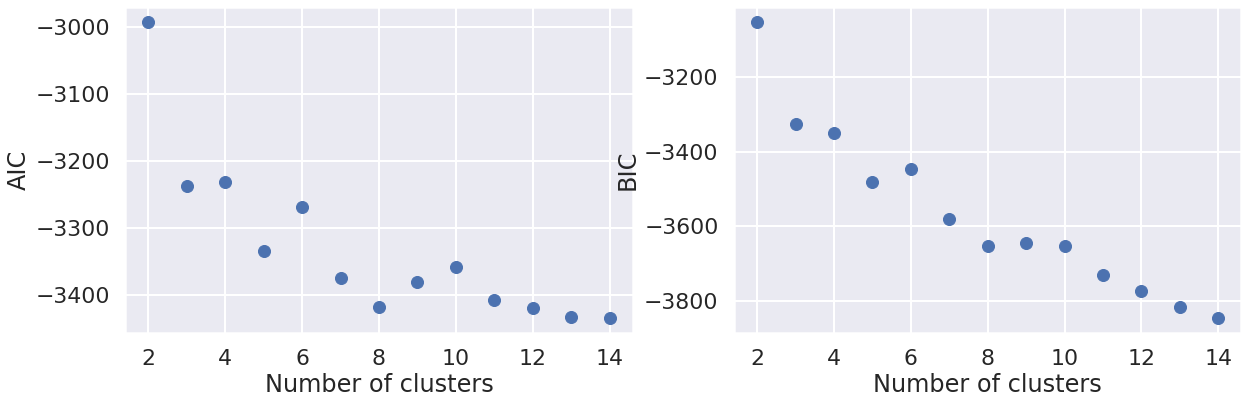

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(nb_clusters, AIC_1, 'o', label="AIC")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("AIC")

ax2.plot(nb_clusters, BIC_1, 'o', label="BIC")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("BIC")
plt.show()

In [ ]:
gmm_1 = my_GMM(10, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
gmm_1 = gmm_1.fit(data_1, print_info=True)

initialization_time = 0.108 s
convergence_time = 1.381 s
delta = 0.007942340418601007
nb_iter = 2


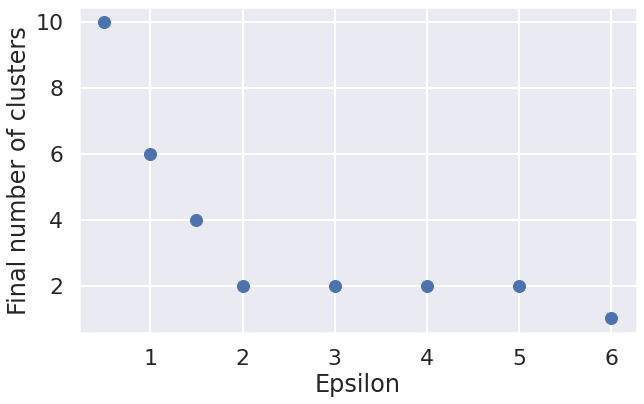

In [ ]:
eps_distance_1 = [0.5, 1, 1.5, 2, 3, 4, 5, 6]
final_nb_clusters_distance_1 = []
for eps_ in eps_distance:
    labels_merge, mu_merge = merge_clusters(X, gmm_1, criterion="distance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_distance_1.append(len(np.unique(labels_merge[-1])))
plt.figure(figsize = (10,6))
plt.plot(eps_distance_1, final_nb_clusters_distance_1, 'o')
plt.xlabel("Epsilon")
plt.ylabel("Final number of clusters")
plt.show()

In [331]:
eps_variance_1 = [0.25, 0.2, 0.15, 0.1, 0.05, 0]
final_nb_clusters_variance_1 = []
for eps_ in eps_variance_1:
    labels_merge, mu_merge = merge_clusters(data_1, gmm_1, criterion="intra_variance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_variance_1.append(len(np.unique(labels_merge[-1])))

In [332]:
eps_pearson_1 = [0.2, 0.5, 0.7]
final_nb_clusters_pearson_1 = []
for eps_ in eps_pearson_1:
    labels_merge, mu_merge = merge_clusters(data_1, gmm_1, criterion="pearson_correlation", nb_merges_max=9, eps= eps_)
    final_nb_clusters_pearson_1.append(len(np.unique(labels_merge[-1])))

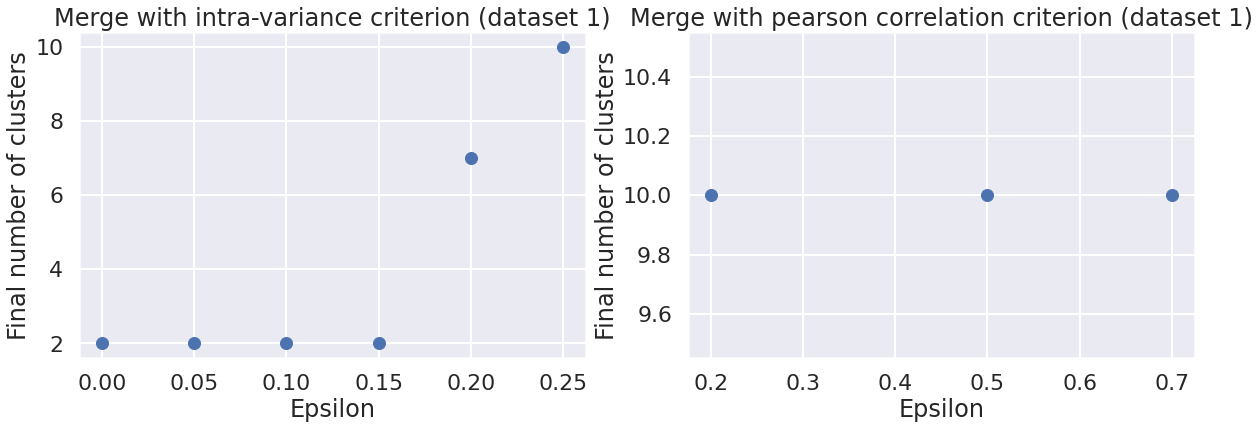

In [333]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(eps_variance_1, final_nb_clusters_variance_1, 'o')
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Final number of clusters")
ax1.set_title("Merge with intra-variance criterion (dataset 1)")

ax2.plot(eps_pearson_1, final_nb_clusters_pearson_1, 'o')
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Final number of clusters")
ax2.set_title("Merge with pearson correlation criterion (dataset 1)")
plt.show()

Model order selection and reduction (expect pearson correlation) agree on the number of clusters (=2). 
- We have two condense clusters round-shaped which maximizes the likelihood (and minimizes the number of parameters). This is why AIC and BIC favors this number of clusters.
- The two clusters are well-separated so the distance criterion in the model reduction tends to give a stable merge at this value.
- The intravariance is minimized because we start by close clusters (at the start of the merge) and we obtain finally condense clusters.
- The pearson correlation does not seem to find similarity between the clusters at the start, so it does not help in the model order reduction.

In [346]:
labels_merge_1, mu_merge_1 = merge_clusters(data_1, gmm_1, criterion="distance", nb_merges_max=9, eps= 3.5, info=True)

Final number of clusters = 2


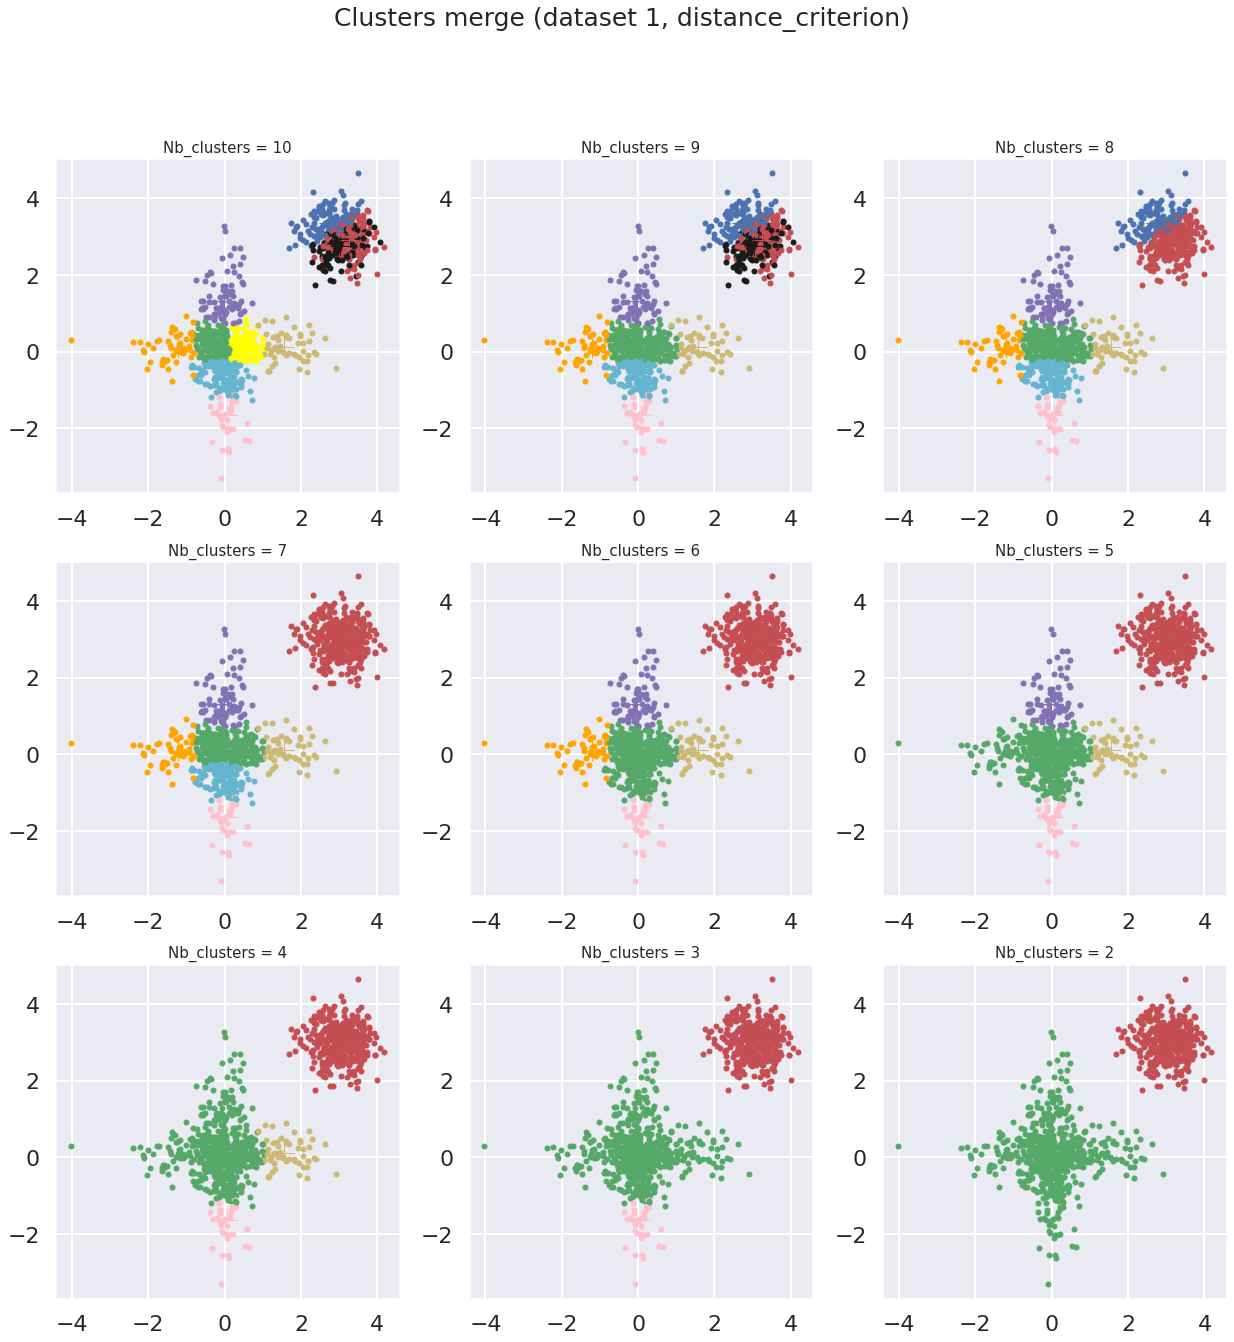

In [347]:
plot_subplot_data(data_1, (0,1), None, labels_merge_1, mu_merge_1, size=21, title="Clusters merge (dataset 1, distance_criterion)", markersize=5)

In [ ]:
nb_clusters = range(2,11)
AIC_2 = []
BIC_2 = []
for K in nb_clusters:
    gmm_k2 = my_GMM(K, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
    gmm_k2 = gmm_k2.fit(data_2, print_info=False)
    aic_2 = AIC(data_2, gmm_k2)
    bic_2 = BIC(data_2, gmm_k2)

    AIC_2.append(aic_2)
    BIC_2.append(bic_2)

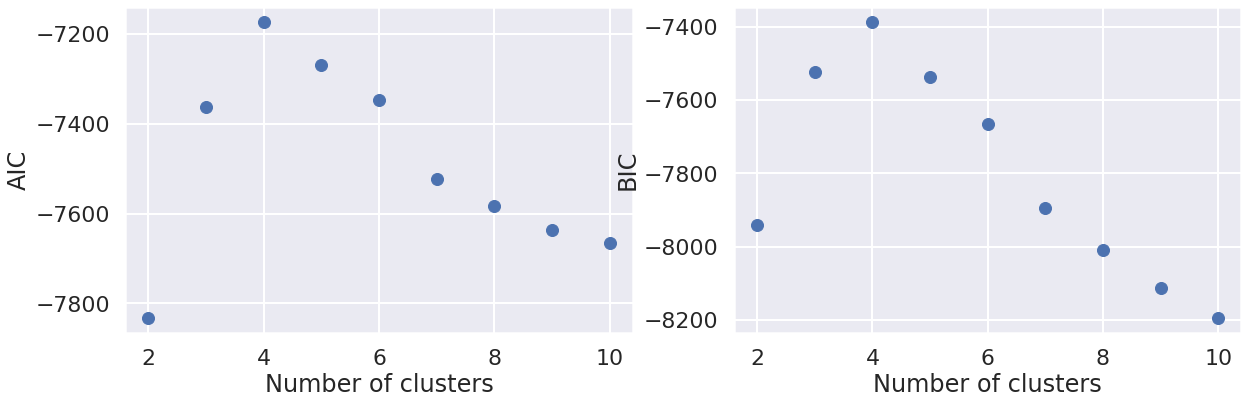

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(nb_clusters, AIC_2, 'o', label="AIC")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("AIC")

ax2.plot(nb_clusters, BIC_2, 'o', label="BIC")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("BIC")
plt.show()

In [335]:
gmm_2 = my_GMM(10, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
gmm_2 = gmm_2.fit(data_2, print_info=True)

initialization_time = 0.146 s
convergence_time = 1.959 s
delta = 0.007066481921814516
nb_iter = 2


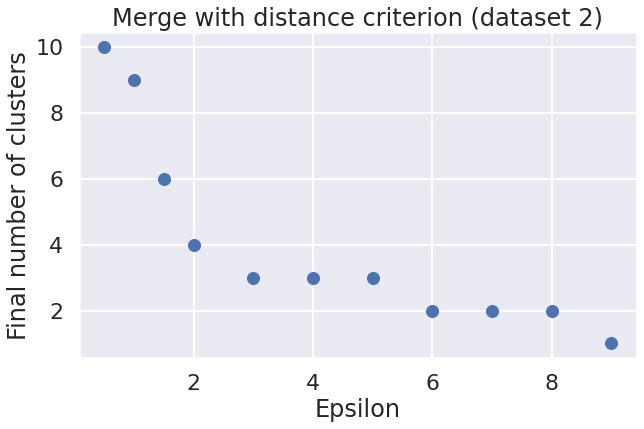

In [336]:
eps_distance_2 = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
final_nb_clusters_distance_2 = []
for eps_ in eps_distance_2:
    labels_merge, mu_merge = merge_clusters(X, gmm_2, criterion="distance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_distance_2.append(len(np.unique(labels_merge[-1])))
plt.figure(figsize = (10,6))
plt.plot(eps_distance_2, final_nb_clusters_distance_2, 'o')
plt.xlabel("Epsilon")
plt.ylabel("Final number of clusters")
plt.title("Merge with distance criterion (dataset 2)")
plt.show()

In [337]:
eps_variance_2 = [0.7, 0.6, 0.5, 0.4, 0]
final_nb_clusters_variance_2 = []
for eps_ in eps_variance_2:
    labels_merge, mu_merge = merge_clusters(data_2, gmm_2, criterion="intra_variance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_variance_2.append(len(np.unique(labels_merge[-1])))

In [340]:
eps_pearson_2 = [0.2, 0.5, 0.7]
final_nb_clusters_pearson_2 = []
for eps_ in eps_pearson_2:
    labels_merge, mu_merge = merge_clusters(data_2, gmm_2, criterion="pearson_correlation", nb_merges_max=9, eps= eps_)
    final_nb_clusters_pearson_2.append(len(np.unique(labels_merge[-1])))

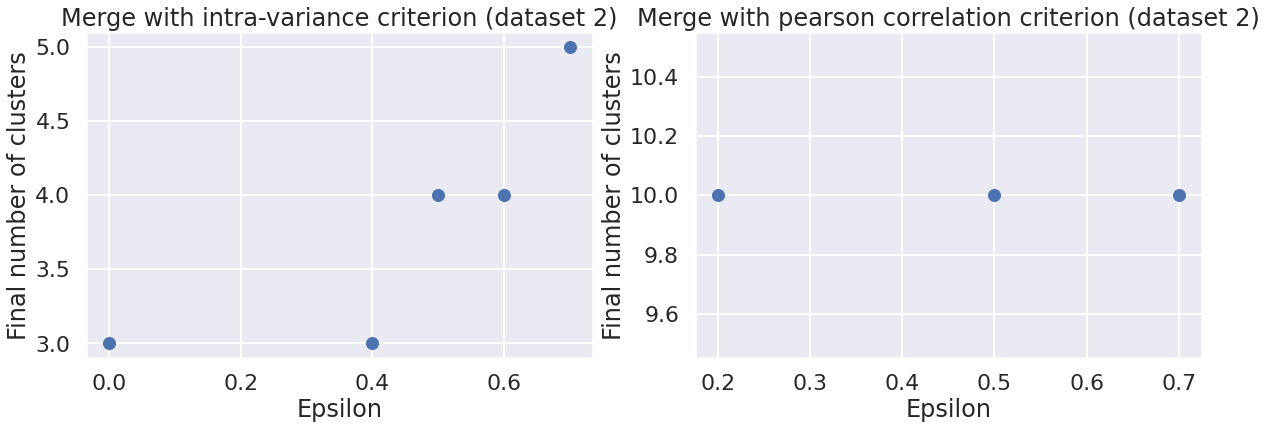

In [341]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(eps_variance_2, final_nb_clusters_variance_2, 'o')
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Final number of clusters")
ax1.set_title("Merge with intra-variance criterion (dataset 2)")

ax2.plot(eps_pearson_2, final_nb_clusters_pearson_2, 'o')
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Final number of clusters")
ax2.set_title("Merge with pearson correlation criterion (dataset 2)")
plt.show()

On this dataset, the methods give different results. By plotting the data (below), we understand why each method behaves differently
- The AIC and BIC tend to favor condense round clusters, that's why it separates the right agglomeration of data into 3 clusters with the same size and leaves the left agglomeration of data into 1 cluster. So we have overall 4 clusters.
- The distance criterion give two stable regions (2 or 3 clusters): it merges 2 of the three clusters in the right agglomeration but it fails to capture the correct shape when it tries to merge further, which shows the limits of this method: it does not take into account the data distribution but only the position of the centroids which give like in this case a bad result.
- The intravariance favors 3 or 4 clusters (from the plot above) but we see from the merge procedure (below) that it obtains better results with a final number of clusters equal to 3: it is more suitable that the other methods to detect the spatial density of the data and to change the shape of the clusters to fit to the data spatial distribution because it relies on its variance.
- The pearson correlation does not detect similar distributions between the clusters.
These remarks are based on a 2D plot of the data, but we need to observe the data in the other dimensions to make more conclusive affirmation.

In [348]:
labels_merge_2, mu_merge_2 = merge_clusters(data_2, gmm_2, criterion="distance", nb_merges_max=9, eps= 6, info=True)

Final number of clusters = 2


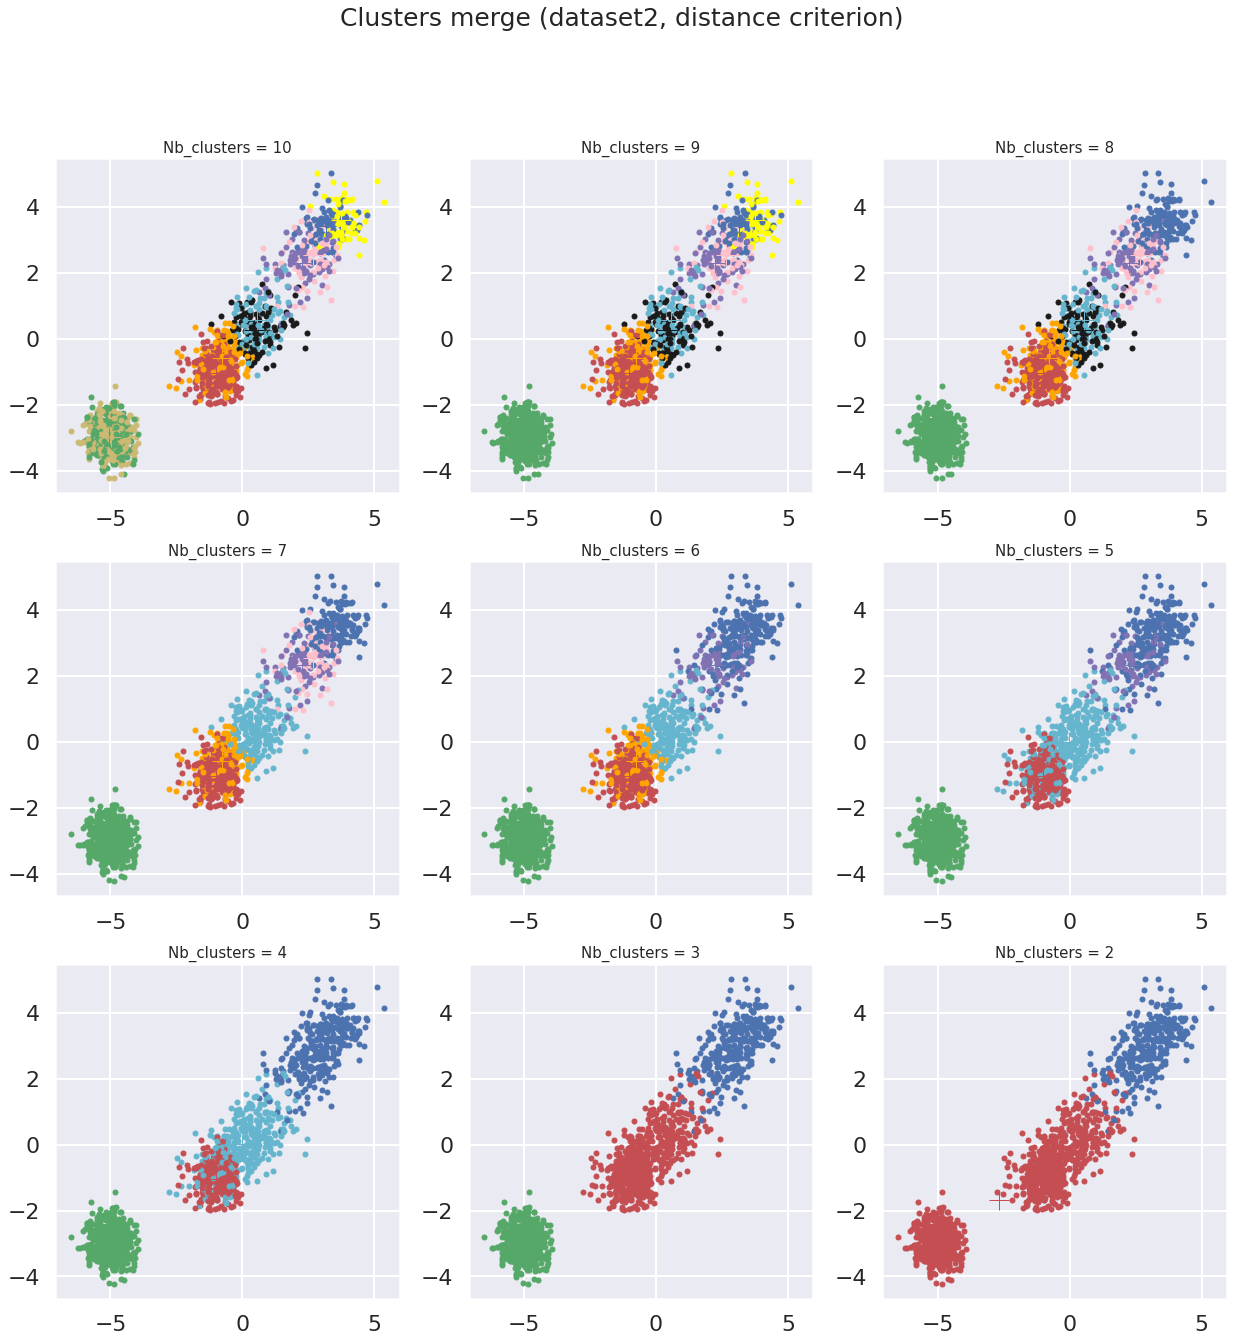

In [351]:
plot_subplot_data(data_2, (0, 1), None, labels_merge_2, mu_merge=mu_merge_2, size=21, title="Clusters merge (dataset2, distance criterion)", markersize=5)

In [355]:
labels_merge_2b, mu_merge_2b = merge_clusters(data_2, gmm_2, criterion="intra_variance", nb_merges_max=9, eps= 0.4, info=True)

Final number of clusters = 3


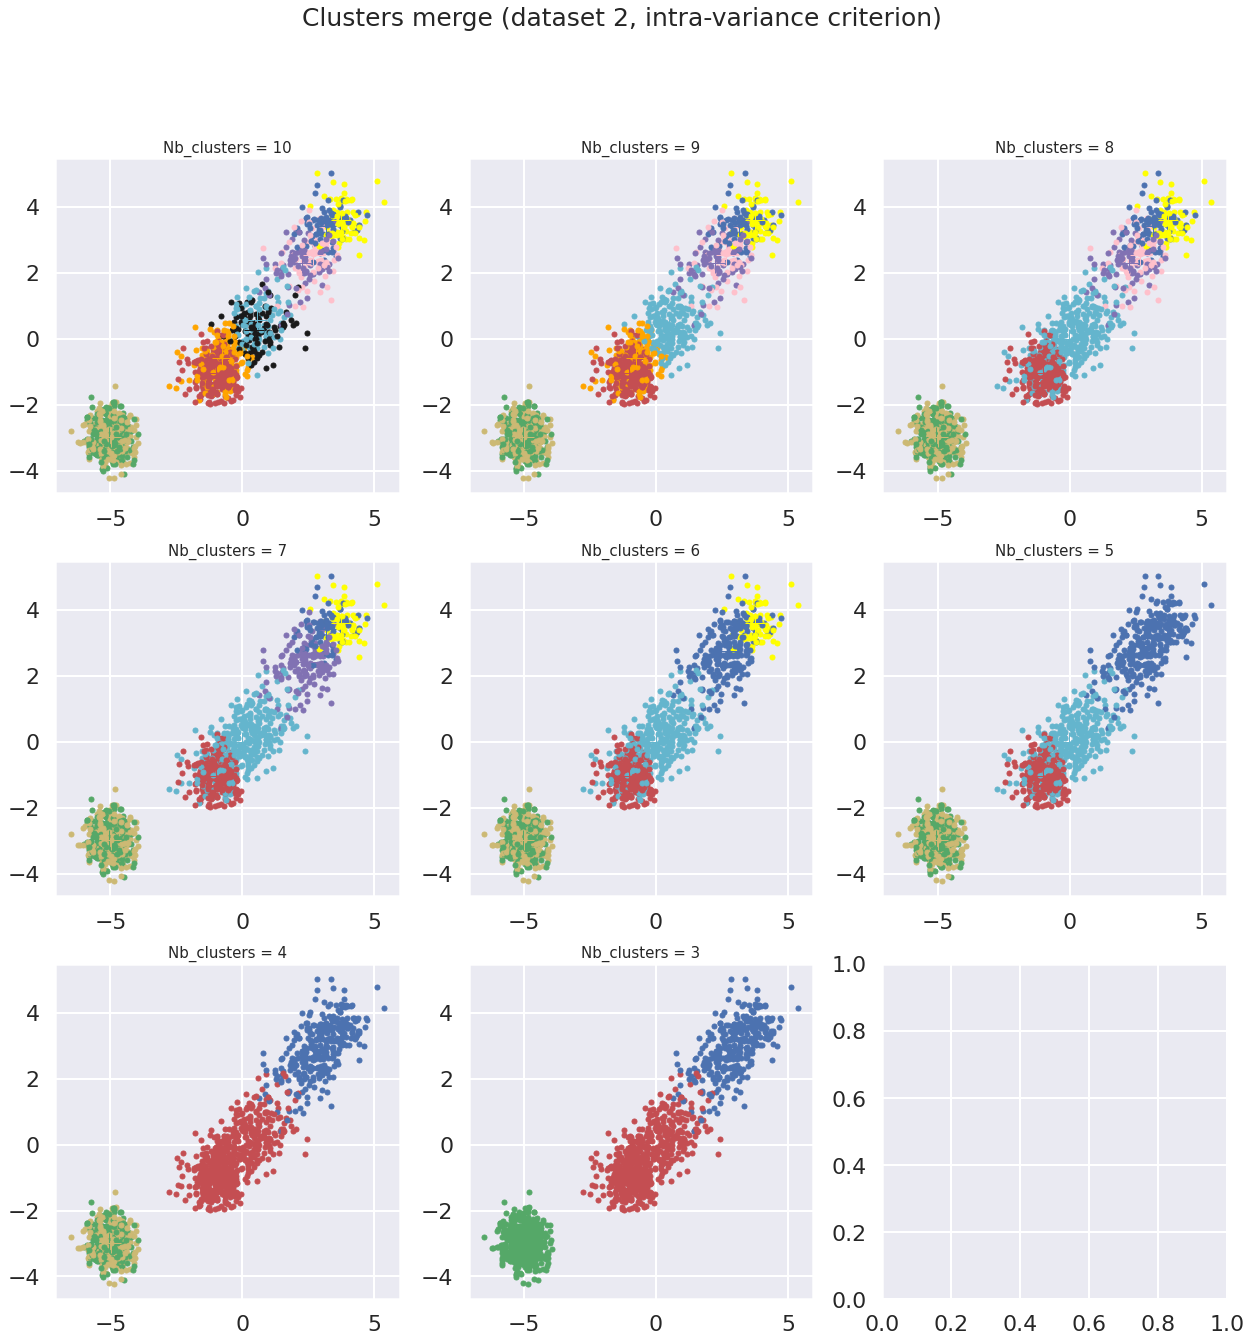

In [356]:
plot_subplot_data(data_2, (0, 1), None, labels_merge_2b, mu_merge=mu_merge_2b, size=21, title="Clusters merge (dataset 2, intra-variance criterion)", markersize=5)

## Application

You are going to work with the following data:

shape: (1797, 64)


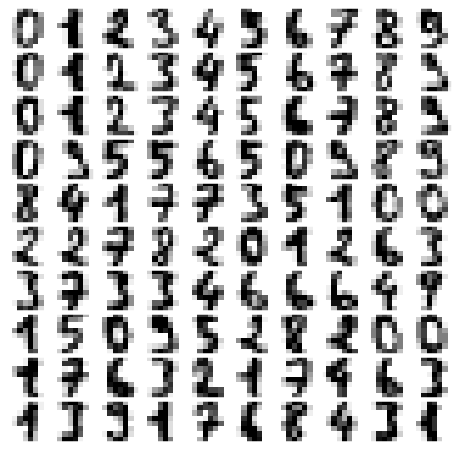

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components_list = [2, 4, 6, 8, 10, 12, 14]
rand_index = []
exec_time = []
for n_components_ in n_components_list:
    pca_n = PCA(n_components = n_components_)
    data_n = pca_n.fit_transform(digits.data)
    gmm_3n = my_GMM(k=10, init_method="kmeans", nb_iter_max=100, eps=1e-2, random_state=7)
    gmm_3n = gmm_3n.fit(data_n)
    exec_time.append(gmm_3n.conv_time_ + gmm_3n.init_time_)
    rand_index.append(np.round(metrics.adjusted_rand_score(digits.target, gmm_3n.labels_), 5))

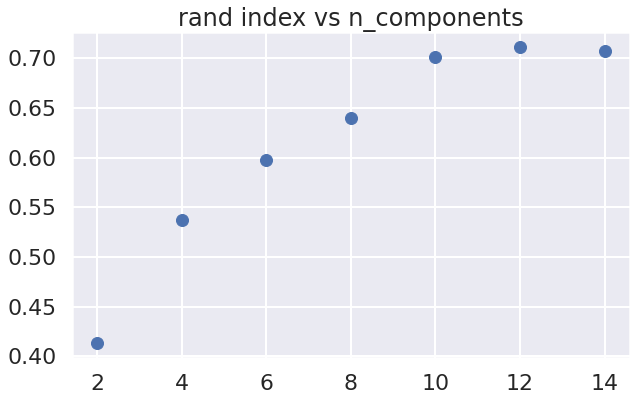

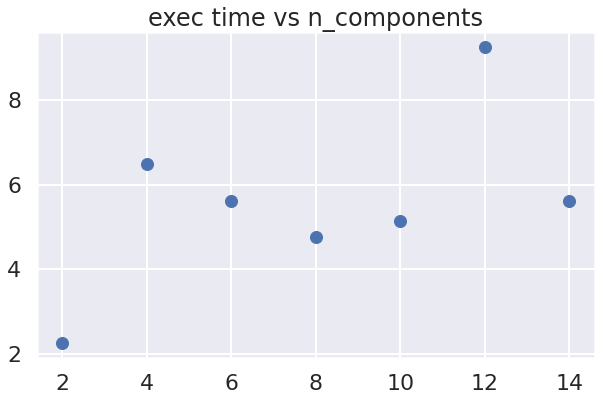

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, rand_index, 'o')
plt.title("rand index vs n_components")
plt.figure(figsize=(10, 6))
plt.plot(n_components_list, exec_time, 'o')
plt.title("exec time vs n_components")
plt.show()

We begin by selecting the number of components that we use for the pca. We see that a number of components equal to 10 gives a good rand index without increasing too much the computational time.

In [357]:
pca = PCA(n_components = 10)
data = pca.fit_transform(digits.data)
print(data.shape)

(1797, 10)


In [363]:
gmm_3_ini = my_GMM(k=10, init_method="kmeans", nb_iter_max=100, eps=1e-2, random_state=7)
gmm_3_ini = gmm_3_ini.fit(data, print_info=True)

initialization_time = 0.225 s
convergence_time = 4.975 s
delta = 0.008148695713755223
nb_iter = 4


In [364]:
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(digits.target, gmm_3_ini.labels_), 5)}")

Adjusted Rand Index = 0.70352


In [361]:
nb_clusters = np.arange(5, 16)
AIC_3 = []
BIC_3 = []
for K in nb_clusters:
    gmm_3k = my_GMM(K, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
    gmm_3k = gmm_3k.fit(data, print_info=False)
    aic_3 = AIC(data, gmm_3k)
    bic_3 = BIC(data, gmm_3k)

    AIC_3.append(aic_3)
    BIC_3.append(bic_3)

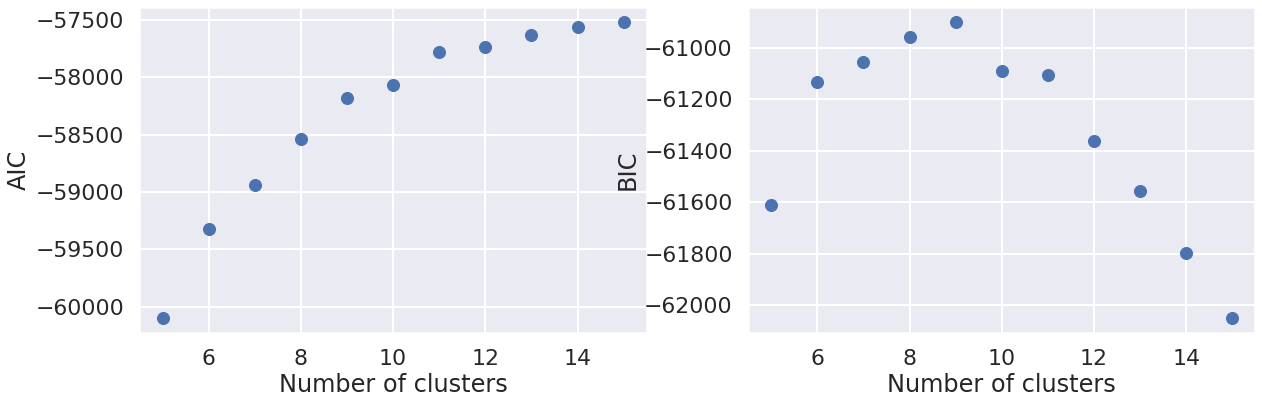

In [362]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(nb_clusters, AIC_3, 'o', label="AIC")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("AIC")

ax2.plot(nb_clusters, BIC_3, 'o', label="BIC")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("BIC")
plt.show()

In [400]:
gmm_3 = my_GMM(20, init_method="kmeans", nb_iter_max=200, eps=1e-2, random_state=7)
gmm_3 = gmm_3.fit(data, print_info=True)

initialization_time = 0.366 s
convergence_time = 9.448 s
delta = 0.008048081782492817
nb_iter = 4


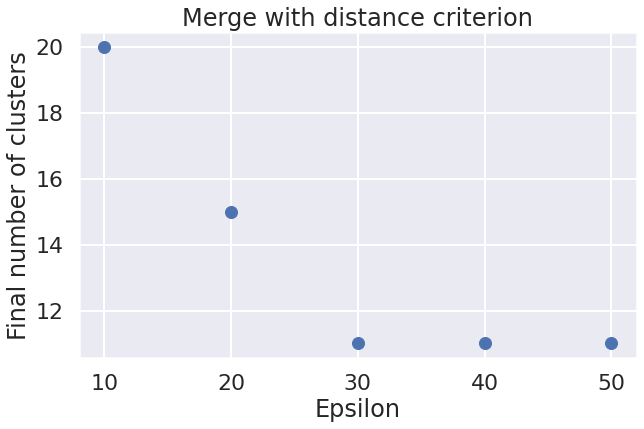

In [401]:
eps_distance_3 = [10, 20, 30, 40, 50]
final_nb_clusters_distance_3 = []
for eps_ in eps_distance_3:
    labels_merge, mu_merge = merge_clusters(data, gmm_3, criterion="distance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_distance_3.append(len(np.unique(labels_merge[-1])))
plt.figure(figsize = (10,6))
plt.plot(eps_distance_3, final_nb_clusters_distance_3, 'o')
plt.xlabel("Epsilon")
plt.ylabel("Final number of clusters")
plt.title("Merge with distance criterion")
plt.show()

In [402]:
eps_variance_3 = [0, 10, 20]
final_nb_clusters_variance_3 = []
for eps_ in eps_variance_3:
    labels_merge, mu_merge = merge_clusters(data, gmm_3, criterion="intra_variance", nb_merges_max=9, eps= eps_)
    final_nb_clusters_variance_3.append(len(np.unique(labels_merge[-1])))

In [420]:
eps_pearson_3 = [0.1, 0.2, 0.3]
final_nb_clusters_pearson_3 = []
for eps_ in eps_pearson_3:
    labels_merge, mu_merge = merge_clusters(data, gmm_3, criterion="pearson_correlation", nb_merges_max=9, eps= eps_)
    final_nb_clusters_pearson_3.append(len(np.unique(labels_merge[-1])))

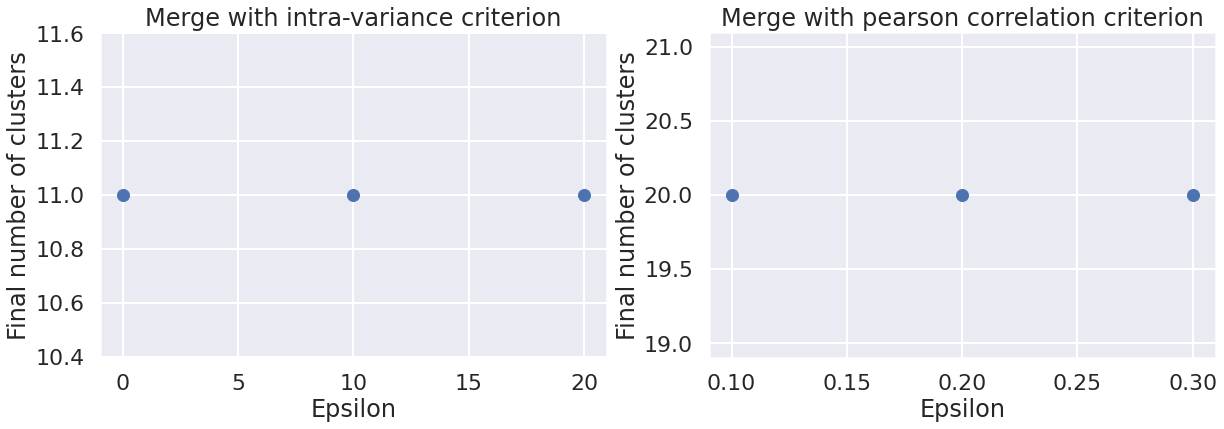

In [421]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(eps_variance_3, final_nb_clusters_variance_3, 'o')
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Final number of clusters")
ax1.set_title("Merge with intra-variance criterion")

ax2.plot(eps_pearson_3, final_nb_clusters_pearson_3, 'o')
ax2.set_xlabel("Epsilon")
ax2.set_ylabel("Final number of clusters")
ax2.set_title("Merge with pearson correlation criterion")
plt.show()

Hand-written digits tend to have different shapes even for the same digit because there are different ways of writing the same number(depending on the person). So we have in the dataset many data clusters (more than 10) which correspond to different ways of righting the digits. We want to reduce this number of clusters to 10, so a model order reduction method is more suitable.
<br> In fact, we see that the model order selection methods (AIC, BIC) do not give the correct number of clusters and do not agree on the same value.
<br> For the model order reduction methods, the distance criterion and intravariance criterion give 11 clusters which is not the best value, but we see that they agre on that number which means that there's a digit that is written completely in two different ways. We see (below) that we have a better rand index using 11 clusters (RI = 0.78) that 10 clusters (RI = 0.70), which validates this approach.

In [424]:
gmm_3_ini = my_GMM(k=10, init_method="kmeans", nb_iter_max=100, eps=1e-2, random_state=7)
gmm_3_ini = gmm_3_ini.fit(data, print_info=True)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(digits.target, gmm_3_ini.labels_), 5)}")

initialization_time = 0.21 s
convergence_time = 5.052 s
delta = 0.008148695713755223
nb_iter = 4
Adjusted Rand Index = 0.70352


In [423]:
gmm_3_fin = my_GMM(k=11, init_method="kmeans", nb_iter_max=100, eps=1e-2, random_state=7)
gmm_3_fin = gmm_3_fin.fit(data, print_info=True)
print(f"Adjusted Rand Index = {np.round(metrics.adjusted_rand_score(digits.target, gmm_3_fin.labels_), 5)}")

initialization_time = 0.237 s
convergence_time = 5.396 s
delta = 0.004777489753432771
nb_iter = 4
Adjusted Rand Index = 0.7805
